<font size=3><strong>Intro</strong></font><br />
The goal of this article is to describe how to back-test a technical indicator-based strategy on python. I will specifically use a Bollinger band-based strategy to create signals and positions.

<font size=3><strong>Description of strategy</strong></font><br />
Create 20-day (+/- 2 standard deviations) Bollinger bands on the adjusted close price. Buy, when the price crosses the lower band from the top and hold until the price crosses the upper band from below the next time. Sell when the price crosses the upper band from below and hold until the price crosses the lower band from the top the next time.

<font size=3><strong>Here are the steps to create your own back-testing code.</strong></font> <br />

1. Import necessary libraries
2. Download OHLCV Data
3. Calculate daily returns
4. Create strategy-based data columns
5. Create strategy indicators
6. Create signals and positions
7. Analyze results

<font size=3><strong>Step 1 : Import necessary libraries</strong></font>

In [10]:
import warnings

# Ignore printing all warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
from typing import Dict,List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os

# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [11]:
someStocks = 'xela msft aapl goog gold silv'.split(' ')

# store dataframes here...
stockResults:Dict[str,pd.DataFrame] = dict()


def download_stock_df(stock:str,start:dt.date,end:dt.date)->pd.DataFrame:
    return yf.download(stock,start,end)

def calc_daily_returns(df:pd.DataFrame):
    df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
    return df

def fmt_moving_avg_name(window:int)->str:
    return "moving_average_"+str(window)+"_day"

def create_bb_indicators(df, ma_window=20,band_bound_factor=2):
    maname=fmt_moving_avg_name(ma_window)
    df[maname] = df['Adj Close'].rolling(window=ma_window).mean()
    df['std'] = df['Adj Close'].rolling(window=ma_window).std()
    df['upper_band'] = df[maname] + (band_bound_factor * df['std'])
    df['lower_band'] = df[maname] - (band_bound_factor * df['std'])
    df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
    return df

def create_strategy_indicators(df):
    # BUY condition
    df['signal'] = np.where( (df['Adj Close'] < df['lower_band']) &
                              (df['Adj Close'].shift(1) >= df['lower_band']),1,0)

    # SELL condition
    df['signal'] = np.where( (df['Adj Close'] > df['upper_band']) &
                              (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal'])
    # creating long and short positions 
    df['position'] = df['signal'].replace(to_replace=0, method='ffill')

    # shifting by 1, to account of close price return calculations
    df['position'] = df['position'].shift(1)

    # calculating stretegy returns
    df['strategy_returns'] = df['bnh_returns'] * (df['position'])

    return df

<font size=3><strong>Step 2 : Download OHLCV: (Open, High, Low, Close, Volume) data</strong></font></br>
I use yahoo finance python API - yfinance to get the data. There are a lot of resources to get historical data in order to backtest your strategies.

In [2]:
# downloading historical necessary data for backtesting and analysis
_start = dt.date(2015,1,2)
_end = dt.date(2020,4,30)
ticker = 'MSFT'
df = download_stock_df(ticker,_start,_end)

[*********************100%***********************]  1 of 1 completed


<font size=3><strong>Step 3 : Calculate daily returns</strong></font></br>
This step calculates daily returns for comparing performance with the buy and hold strategy. A buy and hold strategy becomes a benchmark or comparing the strategy. In other words, it checks if the strategy performed better than simply buying and holding the stock. A good strategy would essentially perform better than a buy-and-hold strategy.

In [3]:
# calculating buy and hold strategy returns
df=calc_daily_returns(df)
df.head(3)
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,bnh_returns
Date,,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,41.108833,27913900,NaN
2015-01-05,46.369999,46.730000,46.250000,46.330002,40.730808,39673900,-0.009238
2015-01-06,46.380001,46.750000,45.540001,45.650002,40.132992,36447900,-0.014786


,Open,High,Low,Close,Adj Close,Volume,bnh_returns
Date,,,,,,,
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.906982,33194400,-0.002869
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.743546,34392700,-0.024662
2020-04-29,173.220001,177.679993,171.880005,177.429993,174.225922,51286600,0.043896


<font size=3><strong>Step 4 : Create strategy-based data columns</strong></font></br>
The next step is to create indicators to generate conditions of the strategy. For Bollinger band strategy, involves the 20-day moving average, the standard deviation of the 20 days moving average, upper band, and lower band of the standard deviation. [ma20,std,upper_band,lower_band]

In [4]:
# creating bollinger band indicators
df=create_bb_indicators(df)
df.tail(5)

,Close,Adj Close,Volume,bnh_returns,moving_average_20_day,std,upper_band,lower_band
Date,,,,,,,,
2020-04-23,171.419998,168.324478,32790800,-0.012176,161.948233,8.587769,179.123772,144.772694
2020-04-24,174.550003,171.397949,34277600,0.018095,162.853584,8.581501,180.016586,145.690581
2020-04-27,174.050003,170.906982,33194400,-0.002869,164.049097,7.894144,179.837385,148.260810
2020-04-28,169.809998,166.743546,34392700,-0.024662,164.519447,7.752113,180.023673,149.015222
2020-04-29,177.429993,174.225922,51286600,0.043896,165.487641,7.691458,180.870557,150.104725


<font size=3><strong>Step 5 : Create strategy indicators</strong></font></br>
The following is the most crucial part of creating the strategy. It involves
- generating long and short signals as mentioned in the strategy
- replacing zeros with forwarding fill, to generate long and short positions
- shifting positions by 1 to signify return calculations done from close of a day to the next day close price

Signals are essentially indicators that signify the action that needs to be taken (ie: to buy or sell). Positions are what you maintain after buying or selling (ie: going long or short).

In [5]:
df=create_strategy_indicators(df)

df.tail(5)

,Close,Adj Close,Volume,bnh_returns,moving_average_20_day,std,upper_band,lower_band,signal,position,strategy_returns
Date,,,,,,,,,,,
2020-04-23,171.419998,168.324478,32790800,-0.012176,161.948233,8.587769,179.123772,144.772694,0,1.0,-0.012176
2020-04-24,174.550003,171.397949,34277600,0.018095,162.853584,8.581501,180.016586,145.690581,0,1.0,0.018095
2020-04-27,174.050003,170.906982,33194400,-0.002869,164.049097,7.894144,179.837385,148.260810,0,1.0,-0.002869
2020-04-28,169.809998,166.743546,34392700,-0.024662,164.519447,7.752113,180.023673,149.015222,0,1.0,-0.024662
2020-04-29,177.429993,174.225922,51286600,0.043896,165.487641,7.691458,180.870557,150.104725,0,1.0,0.043896


<font size=3><strong>Step 6 : Create signals and positions</strong></font></br>
The next step is to compare the strategy performance using cumulative returns. 
 This involves element-wise multiplication of the positions with the daily returns.

Buy and hold returns: 1.4441298363324915
Strategy returns: 0.3712245177387462


<AxesSubplot:xlabel='Date'>

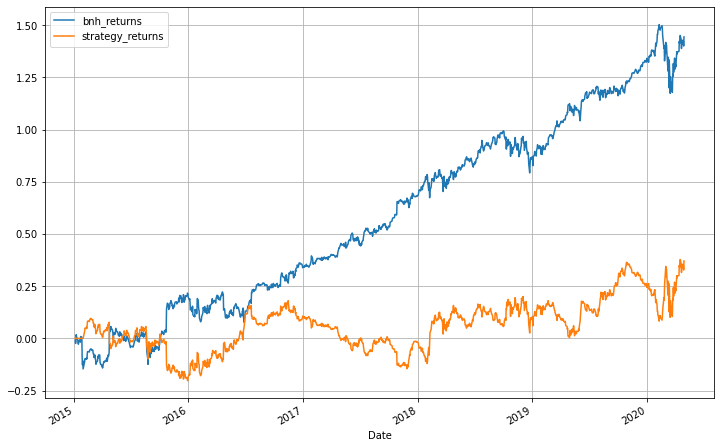

In [6]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

<font size=3><strong>Step 7 : Analyze results</strong></font></br>

For this step I use pyfolio. Pyfolio is a Python library for performance and risk analysis of financial portfolios

Start date,2015-01-02
End date,2020-04-29
Total months,63
,Backtest
Annual return,3.3%
Cumulative returns,19.1%
Annual volatility,27.1%
Sharpe ratio,0.26
Calmar ratio,0.12
Stability,0.16
Max drawdown,-28.6%


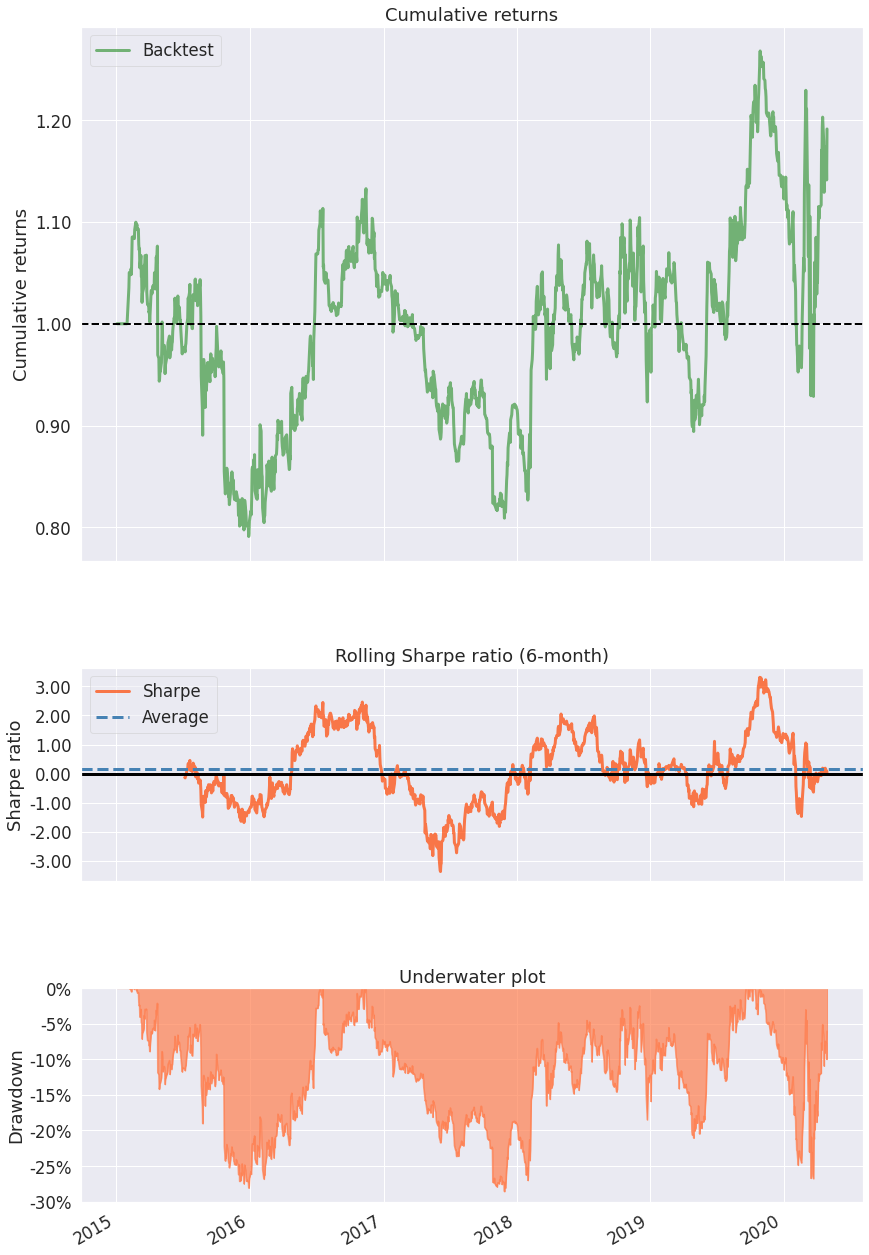

In [7]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())

<font size=3><strong>Comments</strong></font></br>
The results from pyfolio are self-explanatory.

The 'Bollinger band' strategy on the historical data did not perform better than the buy & hold strategy. The cumulative daily returns for buy and hold accounts to 1.44 times the initial investment and the Bollinger band strategy returns account for 0.37 times the initial investment.

For obvious reasons, one should not take a strategy live, even if it gives great returns on back-testing. There are various risks involved such as not accounting for transaction costs and momentum in stock price.

The performance of a strategy can also be optimized by checking the returns on various strategy parameters.

Various other technical indicators can be used in conjunction to create signals which can reduce risks and improve performance. Live strategies should implement stop loss and kill switches in case the strategy goes of hand.

This code snippet can be found at : https://github.com/karthikramx/Algorithmic-Trading-Backtesting-python-example